Shape: (7649, 8)

Missing Values:
 id                  0
latitude           13
longitude          13
day_of_year         0
day_of_week         0
hour                0
month               0
pollution_value     0
dtype: int64

Describe:
                   count         mean          std      min         25%  \
id               7649.0  3824.000000  2208.220437    0.000  1912.00000   
latitude         7636.0    31.880180    17.798504  -74.187    28.94575   
longitude        7636.0    32.100777    97.811786 -161.756   -79.82100   
day_of_year      7649.0   203.554582    79.877375    1.000   151.00000   
day_of_week      7649.0     1.560073     1.792616    0.000     0.00000   
hour             7649.0    11.059877     6.241297    0.000     5.00000   
month            7649.0     7.106811     2.631424    1.000     5.00000   
pollution_value  7649.0    22.813227    46.650639    3.500     8.50000   

                         50%        75%       max  
id               3824.000000  5736.0000  7648

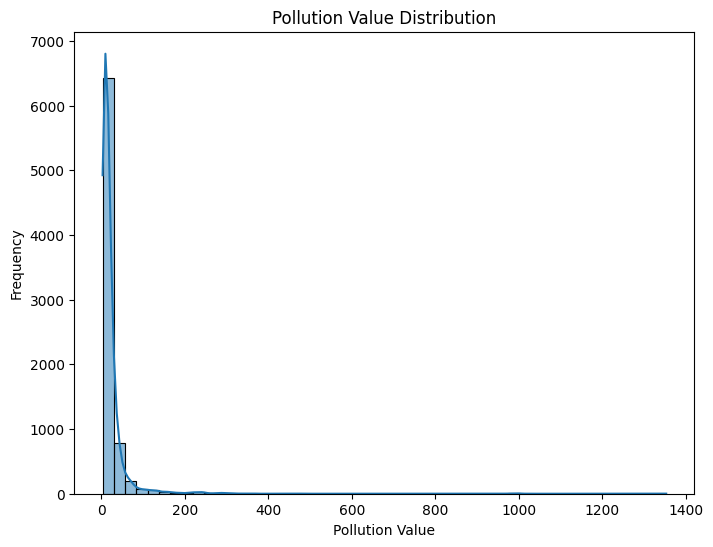

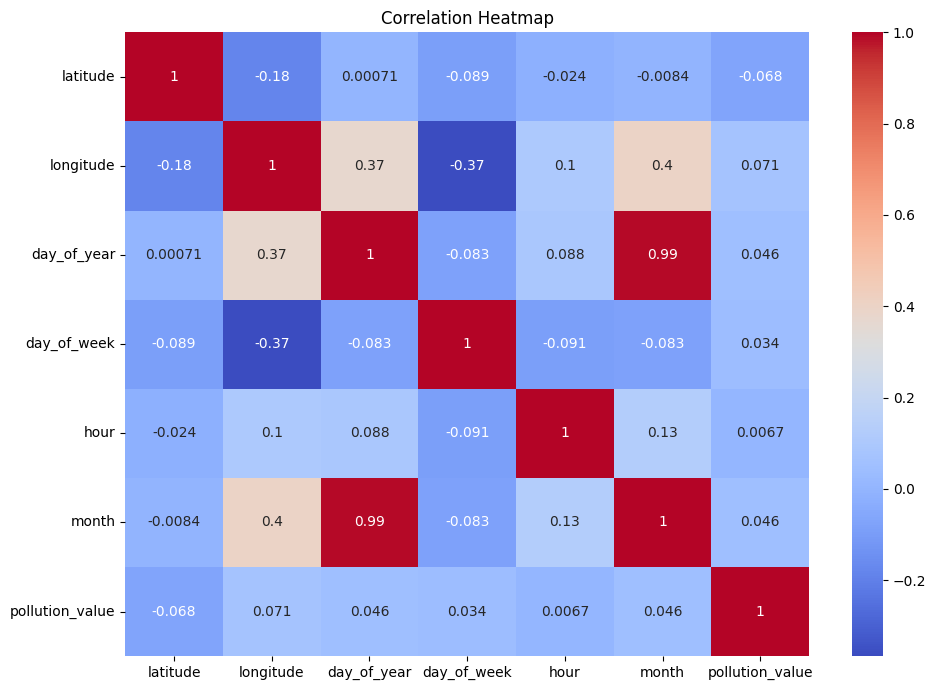

Dropping weak features: ['day_of_year', 'day_of_week', 'month']
Train Shape after FE: (6995, 10)
Test Shape after FE: (2739, 9)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# ========== EDA ==========
def perform_eda(df):
    print("Shape:", df.shape)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nDescribe:\n", df.describe().T)

    plt.figure(figsize=(8, 6))
    sns.histplot(df['pollution_value'], bins=50, kde=True)
    plt.title("Pollution Value Distribution")
    plt.xlabel("Pollution Value")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(10, 7))
    sns.heatmap(df.drop(columns='id').corr(), annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()

perform_eda(train)

# ========== Outlier Removal ==========
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

train = remove_outliers_iqr(train, 'pollution_value')

# ========== Drop Weak Correlated Features ==========
corr = train.drop(columns='id').corr()
target_corr = corr['pollution_value'].drop('pollution_value')
weak_feats = target_corr[abs(target_corr) < 0.05].index.tolist()
print("Dropping weak features:", weak_feats)
train = train.drop(columns=weak_feats)
if weak_feats: test = test.drop(columns=weak_feats)

# ========== Feature Engineering ==========
def feature_engineering(df):
    df = df.copy()
    imputer = SimpleImputer(strategy='median')
    if 'latitude' in df.columns and 'longitude' in df.columns:
        df[['latitude', 'longitude']] = imputer.fit_transform(df[['latitude', 'longitude']])
    if 'hour' in df.columns:
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    if 'day_of_week' in df.columns:
        df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    if 'month' in df.columns:
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    if 'day_of_year' in df.columns:
        df['doy_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 366)
        df['doy_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 366)
    if 'hour' in df.columns and 'month' in df.columns:
        df['hour_x_month'] = df['hour'] * df['month']
    if 'day_of_week' in df.columns and 'hour' in df.columns:
        df['dow_x_hour'] = df['day_of_week'] * df['hour']
    if 'hour' in df.columns:
        df['hour_squared'] = df['hour'] ** 2

    return df

train_fe = feature_engineering(train)
test_fe = feature_engineering(test)

# ========== Geospatial Clustering ==========
coords = pd.concat([train_fe[['latitude', 'longitude']],
                    test_fe[['latitude', 'longitude']]])
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
geo_clusters = kmeans.fit_predict(coords_scaled)

train_fe['geo_cluster'] = geo_clusters[:len(train_fe)]
test_fe['geo_cluster'] = geo_clusters[len(train_fe):]
train_fe['geo_hour_mean'] = train_fe.groupby(['geo_cluster', 'hour'])['pollution_value'].transform('mean')
test_fe['geo_hour_mean'] = test_fe.groupby(['geo_cluster', 'hour'])['hour'].transform(lambda x: train_fe.loc[train_fe['hour'].isin(x.index), 'geo_hour_mean'].mean())

print("Train Shape after FE:", train_fe.shape)
print("Test Shape after FE:", test_fe.shape)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6995 entries, 0 to 7648
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               6995 non-null   int64  
 1   latitude         6982 non-null   float64
 2   longitude        6982 non-null   float64
 3   hour             6995 non-null   int64  
 4   pollution_value  6995 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 327.9 KB


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = train_fe.drop(columns=['id', 'pollution_value'])
y = np.log1p(train_fe['pollution_value'])
#y = train_fe['pollution_value']

X_test = test_fe.drop(columns=['id'])

X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# early stopping
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100
)

val_preds = model.predict(dval)
rmse = mean_squared_error(y_val, val_preds)
r2 = r2_score(y_val, val_preds)

print(f"✅ RMSE on Validation: {rmse:.2f}")
print(f"✅ R² Score on Validation: {r2:.4f}")


[0]	train-rmse:0.53662	eval-rmse:0.55973
[100]	train-rmse:0.34332	eval-rmse:0.38912
[200]	train-rmse:0.31232	eval-rmse:0.38562
[235]	train-rmse:0.30420	eval-rmse:0.38613
✅ RMSE on Validation: 0.15
✅ R² Score on Validation: 0.5435


'\n# Predict on test set\ntest_preds = model.predict(dtest)\n\n# Save submission\nsubmission = pd.DataFrame({\n    \'id\': test_fe[\'id\'],\n    \'pollution_value\': test_preds\n})\nsubmission.to_csv("xgb_submission.csv", index=False)\nprint("📁 Saved as xgb_submission.csv")\n'

In [ ]:
val_preds = np.expm1(model.predict(dval))
test_preds = np.expm1(model.predict(dtest))

In [ ]:
rmse = mean_squared_error(np.expm1(y_val), val_preds)
r2 = r2_score(np.expm1(y_val), val_preds)
rmse

41.78944563478952

In [ ]:
r2

0.5267446735129631

In [ ]:
pip install optuna xgboost scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

X = train_fe.drop(columns=['id', 'pollution_value'])
y = np.log1p(train_fe['pollution_value'])
X_test = test_fe.drop(columns=['id'])
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 10),
        'gamma': trial.suggest_float("gamma", 0, 5),
        'lambda': trial.suggest_float("lambda", 0.01, 5),
        'alpha': trial.suggest_float("alpha", 0.01, 5),
        'verbosity': 0,
        'tree_method': 'hist'
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_list = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=3000,
            evals=[(dtrain, 'train'), (dval, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        preds = model.predict(dval)
        rmse = mean_squared_error(y_val, preds)
        rmse_list.append(rmse)

    return np.mean(rmse_list)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("✅ Best RMSE:", study.best_value)
print("✅ Best params:", study.best_params)
best_params = study.best_params
best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'tree_method': 'hist',
})

dtrain_full = xgb.DMatrix(X, label=y)
dtest = xgb.DMatrix(X_test)

final_model = xgb.train(
    best_params,
    dtrain_full,
    num_boost_round=study.best_trial.number + 100
)


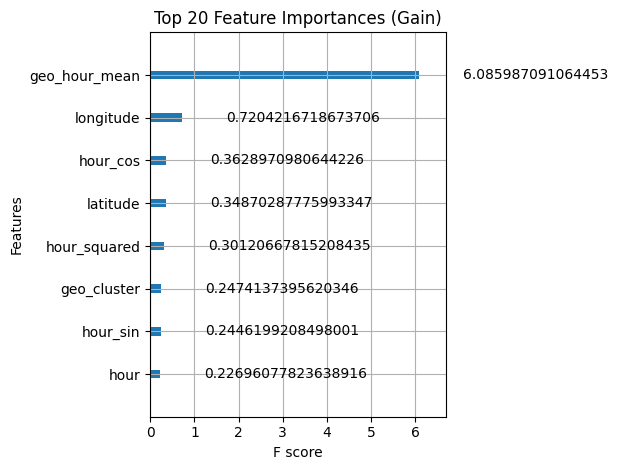

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_importance(final_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

r2_scores = cross_val_score(xgb.XGBRegressor(**best_params), X, y, scoring='r2', cv=5)
print(f"✅ Cross-validated R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")


✅ Cross-validated R²: 0.5069 ± 0.0162


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
lgb_model = LGBMRegressor(random_state=42)
lgb_model.fit(X_res, y_res)

# Blend Predictions (XGB + LGBM)
xgb_preds = np.expm1(final_model.predict(dtest))
lgb_preds = np.expm1(lgb_model.predict(X_test))

blended_preds = 0.6 * xgb_preds + 0.4 * lgb_preds

# Submission
submission_blend = pd.DataFrame({
    'id': test_fe['id'],
    'pollution_value': blended_preds
})
submission_blend.to_csv("xgb_lgbm_blend.csv", index=False)
print("✅ Blended submission saved as xgb_lgbm_blend.csv")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 6995, number of used features: 8
[LightGBM] [Info] Start training from score 2.594807
✅ Blended submission saved as xgb_lgbm_blend.csv


In [ ]:
submission_blend

,id,pollution_value
0,0,9.104555
1,1,15.222375
2,2,8.481920
3,3,14.432706
4,4,11.493561
...,...,...
2734,2734,18.445863
2735,2735,11.562496
2736,2736,10.840431
2737,2737,10.553572


***INFERENCE***

Overall, the notebook provied a clear understanding of air pollution trends by analysing pollutant levels over time . Key steps included data cleaning ,missing value Handling, aggregation, and visualisation. These steps enabled identifying pollution hotspots , trends across months or years, and potentially harmful levels of specific pollutants, which can be useful for policy decisions and public health awareness.

